In [52]:
import os
import act
import xarray as xr
import glob
import pandas as pd

In [2]:
start_date = '20221130'
end_date = '20230517'

# SOS Data

In [53]:
try:
    tidy_df_30Min = pd.read_parquet(f"../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")

try:
    tidy_df_5Min = pd.read_parquet(f"../sos/tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")
    
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])
tidy_df_30Min['time'] = pd.to_datetime(tidy_df_30Min['time'])

# SAIL data

In [3]:
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
ecor_gothic = 'guc30ecorM1.b1'
ecor_kp = 'guc30ecorS3.b1'
met_gothic = 'gucmetM1.b1'
rad_gothic = 'gucgndrad60sM1.b1'
irt_gothic = 'gucgndirtM1.b1'
sebs_kp = 'gucsebsS3.b1'

output_dir = '/data2/elilouis/sublimationofsnow/'

kp_sail_ecor_download_dir = os.path.join(output_dir, ecor_kp)
gothic_sail_ecor_download_dir = os.path.join(output_dir, ecor_gothic)

## Download SEBS data

In [ ]:
kp_sail_sebs_download_dir = os.path.join(output_dir, sebs_kp)
kp_sail_sebs_download_dir

In [ ]:
act.discovery.download_data(
    username,    token,    sebs_kp,    
    start_date,
    end_date,
    output = kp_sail_sebs_download_dir
)

## Download radiation data

In [ ]:
gothic_sail_rad_download_dir = os.path.join(output_dir, rad_gothic)
gothic_sail_rad_download_dir

In [ ]:
act.discovery.download_data(
    username,    token,    rad_gothic,    
    start_date,
    end_date,
    output = gothic_sail_rad_download_dir
)

## Download the infrared thermometer measurements

In [ ]:
gothic_sail_irt_download_dir = os.path.join(output_dir, irt_gothic)
gothic_sail_irt_download_dir

In [ ]:
act.discovery.download_data(
    username,    token,    irt_gothic,    
    start_date,
    end_date,
    output = gothic_sail_irt_download_dir
)

## Open it all

In [65]:
sebs_kp_ds = act.io.armfiles.read_netcdf(
    glob.glob(os.path.join(output_dir, sebs_kp, '*.cdf'))
).sel(time = slice("2023-02-01", "2023-02-08"))
irt_gothic_ds = act.io.armfiles.read_netcdf(
    glob.glob(os.path.join(output_dir, irt_gothic, '*.nc'))
).sel(time = slice("2023-02-01", "2023-02-08"))
rad_gothic_ds = act.io.armfiles.read_netcdf(
    glob.glob(os.path.join(output_dir, rad_gothic, '*.cdf'))
).sel(time = slice("2023-02-01", "2023-02-08"))

In [66]:

from sublimpy import utils
import pytz

In [67]:
sebs_kp_ds = utils.modify_xarray_timezone(sebs_kp_ds, pytz.UTC, pytz.timezone("US/Mountain"))
irt_gothic_ds = utils.modify_xarray_timezone(irt_gothic_ds, pytz.UTC, pytz.timezone("US/Mountain"))
rad_gothic_ds = utils.modify_xarray_timezone(rad_gothic_ds, pytz.UTC, pytz.timezone("US/Mountain"))

In [68]:
STEVEN_BOLTZMAN = 5.67e-08 #W/m^2/degK^4
SNOW_EMMISIVITY = 0.98 

In [69]:


sebs_kp_ds['sfc_ir_temp'] = (
    (
        sebs_kp_ds['up_long'] + STEVEN_BOLTZMAN * (sebs_kp_ds['temp_net_radiometer']+273.15)**4
    ) / (SNOW_EMMISIVITY*STEVEN_BOLTZMAN)
)**(1/4) - 273.15

rad_gothic_ds['sfc_ir_temp'] = (
    (
        rad_gothic_ds['up_long_hemisp'] + STEVEN_BOLTZMAN * (rad_gothic_ds['inst_up_long_hemisp_case_temp'])**4
    ) / (SNOW_EMMISIVITY*STEVEN_BOLTZMAN)
)**(1/4) - 273.15

irt_gothic_ds['sfc_ir_temp'] = irt_gothic_ds['sfc_ir_temp']-273.15

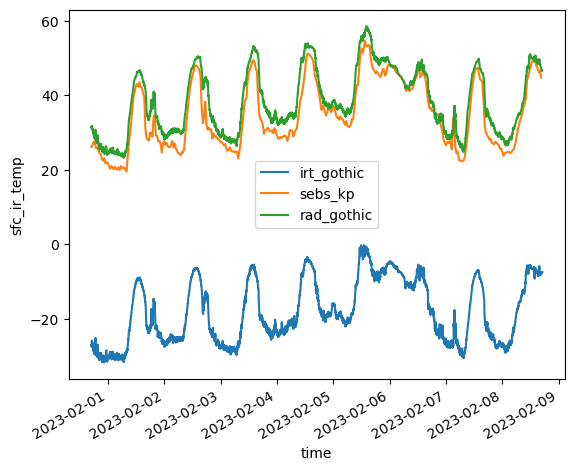

In [70]:
import matplotlib.pyplot as plt
irt_gothic_ds['sfc_ir_temp'].plot(label='irt_gothic')
sebs_kp_ds['sfc_ir_temp'].plot(label='sebs_kp')
rad_gothic_ds['sfc_ir_temp'].plot(label='rad_gothic')
plt.legend()

In [71]:
src = tidy_df_30Min.set_index("time").loc["2023-02-01": "2023-02-08"]
src = src[src.variable.isin(['Tsurf_rad_d', 'Tsurf_c'])]


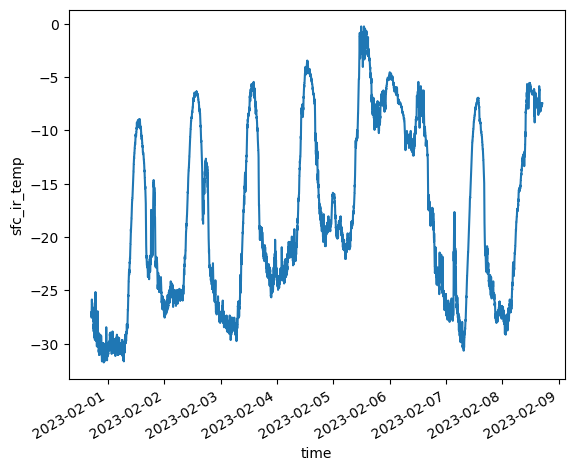

In [77]:
irt_gothic_ds['sfc_ir_temp'].plot(label='SAIL irt Gothic')

In [100]:
src = src.query("variable == 'Tsurf_rad_d'")[['value']].rename(columns={'value': 'Tsurf_rad_d'}).merge(
    src.query("variable == 'Tsurf_c'")[['value']].rename(columns={'value': 'Tsurf_c'}),
    on = 'time'
).merge(
    irt_gothic_ds['sfc_ir_temp'].resample(time='30Min').mean().to_dataframe(),
    on = 'time'
)

,Tsurf_rad_d,Tsurf_c,sfc_ir_temp
time,,,
2023-02-01 00:00:00,-27.825347,-23.478856,-30.429993
2023-02-01 00:30:00,-28.948904,-24.170789,-29.869995
2023-02-01 01:00:00,-28.037643,-23.778791,-29.683327
2023-02-01 01:30:00,-28.511917,-23.699888,-29.969992
2023-02-01 02:00:00,-28.837179,-23.779162,-29.803326
...,...,...,...
2023-02-08 14:30:00,-5.122374,-6.340663,-7.233327
2023-02-08 15:00:00,-6.074800,-7.348073,-7.693326
2023-02-08 15:30:00,-5.003683,-6.038986,-6.643331


In [103]:
import altair as alt

In [109]:
alt.Chart(src.reset_index()).transform_fold(
    ['Tsurf_rad_d', 'Tsurf_c', 'sfc_ir_temp']
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").title('Surface temperature (˚C)'),
    alt.Color("key:N").title("sensor")
).properties(width = 600).display(renderer='svg')

alt.Chart(...)